# Seminar: Advanced Topics in Quantum Computing
## Quantum Optimization - Quantum Relax-and-Round (QRR)

Eraraya Ricardo Muten

Technical University of Munich, Quantum Science & Technology

Mentor: Lilly Palackal

Adapted from “Extending relax-and-round combinatorial optimization solvers with quantum correlations”[1].

Paper by Maxime Dupont and Bhuvanesh Sundar.

This notebook is a prototype implementation for demo. The results of the demo are shown during the presentation. QAOA part is mostly adapted from tutorial documentations of PennyLane (links can be found in 4). References). QRR part (which is the main topic of the presentation) is self-implemented.

## 0). Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pennylane as qml
from pennylane import numpy as np

import gurobipy as gp
from gurobipy import GRB

from collections import defaultdict

## 1). Functions for QRR

As explained in the presentation, QRR steps are as below:

1. Do a QAOA optimization with respect to a certain cost function and obtain the optimized QAOA circuit.<br>
2. Construct the correlation matrix $Z$ by using that optimized circuit, either by direct measurement or estimation from circuit sampling.<br>
3. Find the eigenvectors of the matrix.<br>
4. Do sign-rounding to all the elements of those eigenvectors. Do the reverse sign-rounding as well to take into account the possibility of non-degenerate solutions. This will double the total eigenvectors that we have.<br>
5. From all the eigenvectors, check which eigenvector gives you the best cost value with respect to the cost function used in step 1. This eigenvector is the solution output of this algorithm.

In [ ]:
# This function is for step 2, constructing the Z matrix from bitstring samples of an optimized QAOA circuit

def Z_matrix_from_bitstrings(bitstrings):

    num_nodes = bitstrings.shape[1]
    Z = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i <= j:
                Z[i,j] = (2*np.sum(bitstrings[:, i] == bitstrings[:, j])/len(bitstrings[:, i]) - 1) * ((i == j) - 1)
                if i != j:
                    Z[j,i] = Z[i,j]

    return Z

In [ ]:
# This function is for step 5, finding the best eigenvector

def find_best_eigenvector(eigenvectors, obj_function, args):

    num_eigenvectors = eigenvectors.shape[1]
    cost = obj_function(np.sign(eigenvectors[:,0]), **args)
    best_id = 0

    for i in range(num_eigenvectors-1):
        new_cost = obj_function(np.sign(eigenvectors[:,i+1]), **args)
        if new_cost < cost:
            cost = new_cost
            best_id = i+1

    return np.sign(eigenvectors[:,best_id]), cost, best_id

In [ ]:
# The QRR algorithm

def relax_and_round(Z, obj_function, args):

    eigenvalues, eigenvectors = np.linalg.eig(Z) # step 3 of finding eigenvectors
    eigenvectors = np.concatenate((np.sign(eigenvectors), np.sign(eigenvectors)*-1), axis=1) # step 4 of sign-rounding
    best_solution, min_cost, best_id = find_best_eigenvector(eigenvectors, obj_function, args) # step 5 of finding the best eigenvector

    return best_solution, min_cost

In [ ]:
# This function is a classical cost function for MaxCut, required for QRR functions to determine the best eigenvector

def maxcut_cost(solution_bitstring, W):
    return solution_bitstring @ W @ solution_bitstring/2

In [ ]:
# This function calculates total value (if solution is feasible) for Knapsack, required for QRR functions to determine the best eigenvector

def knapsack_cost(solution_bitstring, weights_list, values_list, max_weight, N):

    feasible, total_weight, total_value = check_solution(0.5*(solution_bitstring[:N]+1), weights_list, values_list, max_weight)

    return -1*total_value

## 2). Problem 1: MaxCut

We want to test the QRR algorithm on 3 MaxCut problems. All problems are 10 random graphs, but each will have 5, 10, and 15 vertices respectively.

### 2.0). Gurobi (classical optimizer) Function to Find the Optimal Solutions

Since we are benchmarking on random graphs, we need a way to obtain the actual optimal solution for each graph so we can normalize our result from QAOA and QRR vs the actual optimal solution. In this demo, we will use Gurobi and assume that it is powerful enough to find the optimal solution.

In [ ]:
def gurobi_opt(N, W, problem_type):
    """Finding solution bitstring with Gurobi Python API.

        Parameters
        ----------
        N : int
            The number of graph vertices.
        W : 2D numpy array or 2D scipy sparse matrix.
            The adjacency matrix, containing the weight of the graph edges.
            W[i,j] = weight between vertex i and j.
            W[i,i] = weight of the vertex i (useful for problems like MIS)
        problem_type : str
            The name of the problem to solve. Choose from options below:
              - "maxcut"
              - "knapsack_slackvar"

        Returns
        -------
        solution_bitstring : 1D numpy array
            A 1D numpy array as the solution output of Gurobi.
        min_obj_val : float
            A value of the objective function using the solution output of Gurobi.
    """

    m = gp.Model("matrix1")
    m.setParam('OutputFlag', False)

    # MIPFocus: 2 is to force the model to focus more attention on proving optimality
    # Read further here https://www.gurobi.com/documentation/current/refman/mipfocus.html
    m.setParam('MIPFocus', 2)

   # generate binary variables in the amount of N (number of vertices)
    x = m.addMVar(shape=N, vtype=GRB.BINARY, name="x")

    # selecting the correct objective function
    if problem_type == "maxcut":
        # MaxCut objective function
        m.setObjective(0.5*(2*x-1) @ W @ (2*x-1), GRB.MINIMIZE)
    if problem_type == "knapsack_slackvar":
        # Knapsack problem with slack variable
        m.setObjective(x @ W @ x, GRB.MINIMIZE)

    m.optimize()

    solution_bitstring = x.X*2 - 1  # convert 0/1 binary to -1/+1 binary
    min_obj_val = m.ObjVal

    return solution_bitstring, min_obj_val

### 2.1). Prepare the Random Graphs

In [ ]:
# set random seed of the random graphs generation for reproducible results
seed_list = [2835, 6911, 8326, 8317, 2852, 8156, 7712, 7647, 8077,  238]

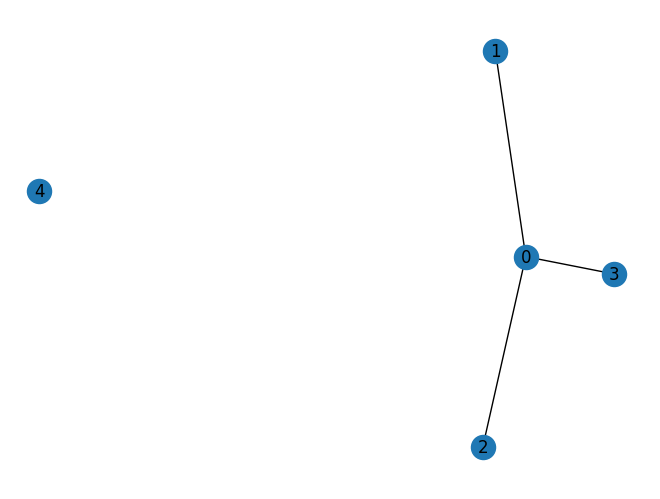

In [ ]:
N_0 = 5
random_graph_0 = []

for random_number in seed_list:
    random_graph_0 += [nx.fast_gnp_random_graph(n=N_0, p=1.2*np.log(N_0)/N_0, seed=int(random_number))]

# check a sample of the random graph
nx.draw(random_graph_0[0], with_labels=True)
plt.show()

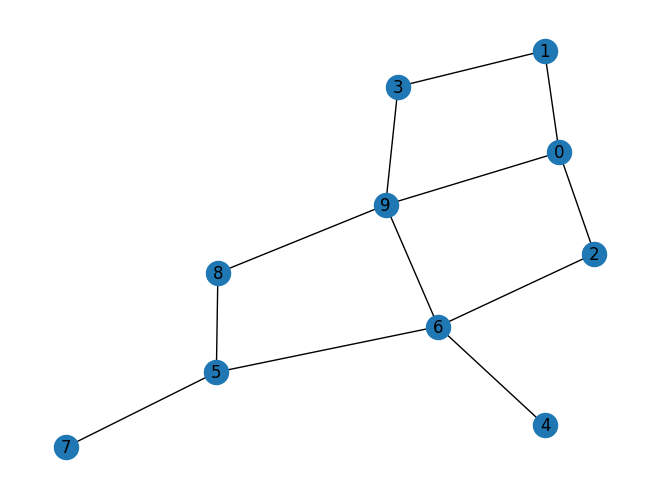

In [ ]:
N_1 = 10
random_graph_1 = []

for random_number in seed_list:
    random_graph_1 += [nx.fast_gnp_random_graph(n=N_1, p=1.2*np.log(N_1)/N_1, seed=int(random_number))]

# check a sample of the random graph
nx.draw(random_graph_1[0], with_labels=True)
plt.show()

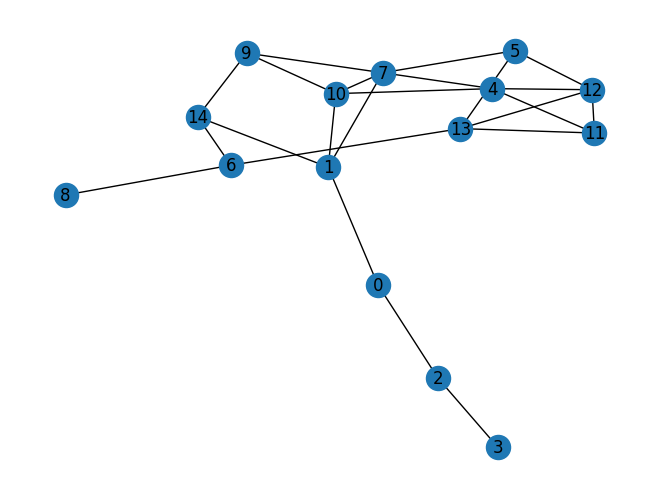

In [ ]:
N_2 = 15
random_graph_2 = []

for random_number in seed_list:
    random_graph_2 += [nx.fast_gnp_random_graph(n=N_2, p=1.2*np.log(N_2)/N_2, seed=int(random_number))]

# check a sample of the random graph
nx.draw(random_graph_2[0], with_labels=True)
plt.show()

### 2.2). QAOA and QRR Implementation of MaxCut

Since the original paper put emphasize on testing the problem with 1-layer depth of QAOA, we will use 1-layer depth here as well. Total shots for the circuit execution is 1000 shots. The classical optimization to optimize QAOA parameters is limited to total of 50 optimization steps, with Adagrad optimizer.

The QAOA implementation is adapted from [2].

In [ ]:
# Operator building blocks for the Mixer Hamiltonian and the Cost Hamiltonian

# unitary operator U_B with parameter beta
def U_B(beta, n_wires):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma, graph, n_wires):
    for edge in graph.edges:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

QAOA Optimization and QRR for the random graphs with 5 vertices.

In [ ]:
n_wires = N_0
dev = qml.device("lightning.qubit", wires=n_wires, shots=1000)

@qml.qnode(dev)
def circuit(gammas, betas, edge, n_wires, n_layers=1):
    # apply Hadamards to get the n qubit |+> state (the initial state)
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p repetitions of unitary operators (p layers)
    for i in range(n_layers):
        U_C(gammas[i], graph, n_wires)
        U_B(betas[i], n_wires)

    if edge is None:
        # measurement phase
        return qml.sample()

    # evaluate the expectation value term that we want to optimize
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

In [ ]:
qaoa_cost_0 = []
qrr_cost_0 = []
gurobi_cost_0 = []

for g in range(len(random_graph_0)):

    graph = random_graph_0[g]

    n_layers = 1

    # initialize the small parameters
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # initialize optimizer
    opt = qml.AdagradOptimizer(stepsize=0.2)

    # minimize the MaxCut objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        temp_obj = 0
        for edge in graph.edges:
            # objective for the MaxCut problem
            temp_obj += circuit(gammas, betas, edge, n_wires=n_wires, n_layers=n_layers)
        return temp_obj

    # optimize parameters
    params = init_params
    steps = 50
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 10 == 0:
            print("Objective (smaller is better) after QAOA optimization step {:5d}: {: .7f}".format(i + 1, objective(params)))

    qaoa_cost_0 += [objective(params)]

    bitstrings = circuit(params[0], params[1], edge=None, n_wires=n_wires, n_layers=n_layers)

    arg_dict = {"W": nx.adjacency_matrix(graph)}
    qrr_cost_0 += [float(relax_and_round(Z_matrix_from_bitstrings(bitstrings), maxcut_cost, arg_dict)[1])]
    gurobi_cost_0 += [gurobi_opt(N_0, nx.adjacency_matrix(graph), problem_type='maxcut')[1]]
    print("For graph " + str(g+1) + ", vanilla QAOA cost | QRR cost | Gurobi cost = ", qaoa_cost_0[-1], qrr_cost_0[-1], gurobi_cost_0[-1])

Objective (smaller is better) after QAOA optimization step    10: -0.5880000
Objective (smaller is better) after QAOA optimization step    20: -1.5940000
Objective (smaller is better) after QAOA optimization step    30: -1.5640000
Objective (smaller is better) after QAOA optimization step    40: -1.6880000
Objective (smaller is better) after QAOA optimization step    50: -1.5760000
For graph 1, vanilla QAOA cost | QRR cost | Gurobi cost =  -1.584 -3.0 -3.0
Objective (smaller is better) after QAOA optimization step    10: -0.8460000
Objective (smaller is better) after QAOA optimization step    20: -1.4200000
Objective (smaller is better) after QAOA optimization step    30: -1.4020000
Objective (smaller is better) after QAOA optimization step    40: -1.2740000
Objective (smaller is better) after QAOA optimization step    50: -1.5920000
For graph 2, vanilla QAOA cost | QRR cost | Gurobi cost =  -1.436 -2.0 -2.0
Objective (smaller is better) after QAOA optimization step    10: -0.9060000
O

In [ ]:
print("QAOA:", qaoa_cost_0)
print("QRR:", qrr_cost_0)
print("Gurobi:", gurobi_cost_0)

QAOA: [-1.584, -1.436, -1.32, -1.832, -2.028, -1.828, -1.4180000000000001, -2.2460000000000004, -1.592, -1.872]
QRR: [-3.0, -2.0, -2.0, -3.0, -4.0, -4.0, -2.0, -4.0, -3.0, -3.0]
Gurobi: [-3.0, -2.0, -2.0, -3.0, -4.0, -4.0, -2.0, -4.0, -3.0, -3.0]


In [ ]:
qaoa_cost_0 = [-1.584, -1.436, -1.32, -1.832, -2.028, -1.828, -1.4180000000000001, -2.2460000000000004, -1.592, -1.872]
qrr_cost_0 = [-3.0, -2.0, -2.0, -3.0, -4.0, -4.0, -2.0, -4.0, -3.0, -3.0]
gurobi_cost_0 = [-3.0, -2.0, -2.0, -3.0, -4.0, -4.0, -2.0, -4.0, -3.0, -3.0]

QAOA Optimization and QRR for the random graphs with 10 vertices.

In [ ]:
n_wires = N_1
dev = qml.device("lightning.qubit", wires=n_wires, shots=1000)

@qml.qnode(dev)
def circuit(gammas, betas, edge, n_wires, n_layers=1):
    # apply Hadamards to get the n qubit |+> state (the initial state)
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p repetitions of unitary operators (p layers)
    for i in range(n_layers):
        U_C(gammas[i], graph, n_wires)
        U_B(betas[i], n_wires)

    if edge is None:
        # measurement phase
        return qml.sample()

    # evaluate the expectation value term that we want to optimize
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

In [ ]:
qaoa_cost_1 = []
qrr_cost_1 = []
gurobi_cost_1 = []

for g in range(len(random_graph_1)):

    graph = random_graph_1[g]

    n_layers = 1

    # initialize the small parameters
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # initialize optimizer
    opt = qml.AdagradOptimizer(stepsize=0.2)

    # minimize the MaxCut objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        temp_obj = 0
        for edge in graph.edges:
            # objective for the MaxCut problem
            temp_obj += circuit(gammas, betas, edge, n_wires=n_wires, n_layers=n_layers)
        return temp_obj

    # optimize parameters
    params = init_params
    steps = 50
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 10 == 0:
            print("Objective (smaller is better) after QAOA optimization step {:5d}: {: .7f}".format(i + 1, objective(params)))

    qaoa_cost_1 += [objective(params)]

    bitstrings = circuit(params[0], params[1], edge=None, n_wires=n_wires, n_layers=n_layers)

    arg_dict = {"W": nx.adjacency_matrix(graph)}
    qrr_cost_1 += [float(relax_and_round(Z_matrix_from_bitstrings(bitstrings), maxcut_cost, arg_dict)[1])]
    gurobi_cost_1 += [gurobi_opt(N_1, nx.adjacency_matrix(graph), problem_type='maxcut')[1]]
    print("For graph " + str(g+1) + ", vanilla QAOA cost | QRR cost | Gurobi cost = ", qaoa_cost_1[-1], qrr_cost_1[-1], gurobi_cost_1[-1])

Objective (smaller is better) after QAOA optimization step    10: -4.8020000
Objective (smaller is better) after QAOA optimization step    20: -4.9080000
Objective (smaller is better) after QAOA optimization step    30: -4.7100000
Objective (smaller is better) after QAOA optimization step    40: -4.8040000
Objective (smaller is better) after QAOA optimization step    50: -5.0280000
For graph 1, vanilla QAOA cost | QRR cost | Gurobi cost =  -4.968 -12.0 -12.0
Objective (smaller is better) after QAOA optimization step    10: -3.6740000
Objective (smaller is better) after QAOA optimization step    20: -3.7940000
Objective (smaller is better) after QAOA optimization step    30: -3.9260000
Objective (smaller is better) after QAOA optimization step    40: -3.7920000
Objective (smaller is better) after QAOA optimization step    50: -4.0060000
For graph 2, vanilla QAOA cost | QRR cost | Gurobi cost =  -3.952 -8.0 -8.0
Objective (smaller is better) after QAOA optimization step    10: -2.8060000

In [ ]:
print("QAOA:", qaoa_cost_1)
print("QRR:", qrr_cost_1)
print("Gurobi:", gurobi_cost_1)

QAOA: [-4.968, -3.952, -3.08, -4.772, -3.778, -4.806000000000001, -4.368, -4.750000000000001, -3.3379999999999996, -4.78]
QRR: [-12.0, -8.0, -5.0, -13.0, -7.0, -10.0, -9.0, -11.0, -6.0, -11.0]
Gurobi: [-12.0, -8.0, -5.0, -13.0, -7.0, -10.0, -9.0, -11.0, -6.0, -11.0]


In [ ]:
qaoa_cost_1 = [-4.968, -3.952, -3.08, -4.772, -3.778, -4.806000000000001, -4.368, -4.750000000000001, -3.3379999999999996, -4.78]
qrr_cost_1 = [-12.0, -8.0, -5.0, -13.0, -7.0, -10.0, -9.0, -11.0, -6.0, -11.0]
gurobi_cost_1 = [-12.0, -8.0, -5.0, -13.0, -7.0, -10.0, -9.0, -11.0, -6.0, -11.0]

QAOA Optimization and QRR for the random graphs with 15 vertices.

In [ ]:
n_wires = N_2
dev = qml.device("lightning.qubit", wires=n_wires, shots=1000)

@qml.qnode(dev)
def circuit(gammas, betas, edge, n_wires, n_layers=1):
    # apply Hadamards to get the n qubit |+> state (the initial state)
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p repetitions of unitary operators (p layers)
    for i in range(n_layers):
        U_C(gammas[i], graph, n_wires)
        U_B(betas[i], n_wires)

    if edge is None:
        # measurement phase
        return qml.sample()

    # evaluate the expectation value term that we want to optimize
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

In [ ]:
qaoa_cost_2 = []
qrr_cost_2 = []
gurobi_cost_2 = []

for g in range(len(random_graph_2)):

    graph = random_graph_2[g]

    n_layers = 1

    # initialize the small parameters
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # initialize optimizer
    opt = qml.AdagradOptimizer(stepsize=0.2)

    # minimize the MaxCut objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        temp_obj = 0
        for edge in graph.edges:
            # objective for the MaxCut problem
            temp_obj += circuit(gammas, betas, edge, n_wires=n_wires, n_layers=n_layers)
        return temp_obj

    # optimize parameters
    params = init_params
    steps = 50
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 10 == 0:
            print("Objective (smaller is better) after QAOA optimization step {:5d}: {: .7f}".format(i + 1, objective(params)))

    qaoa_cost_2 += [objective(params)]

    bitstrings = circuit(params[0], params[1], edge=None, n_wires=n_wires, n_layers=n_layers)

    arg_dict = {"W": nx.adjacency_matrix(graph)}
    qrr_cost_2 += [float(relax_and_round(Z_matrix_from_bitstrings(bitstrings), maxcut_cost, arg_dict)[1])]
    gurobi_cost_2 += [gurobi_opt(N_2, nx.adjacency_matrix(graph), problem_type='maxcut')[1]]
    print("For graph " + str(g+1) + ", vanilla QAOA cost | QRR cost | Gurobi cost = ", qaoa_cost_2[-1], qrr_cost_2[-1], gurobi_cost_2[-1])

Objective (smaller is better) after QAOA optimization step    10: -7.0940000
Objective (smaller is better) after QAOA optimization step    20: -6.9660000
Objective (smaller is better) after QAOA optimization step    30: -6.9560000
Objective (smaller is better) after QAOA optimization step    40: -6.8060000
Objective (smaller is better) after QAOA optimization step    50: -6.8680000
For graph 1, vanilla QAOA cost | QRR cost | Gurobi cost =  -6.73 -17.0 -17.0
Objective (smaller is better) after QAOA optimization step    10: -5.9760000
Objective (smaller is better) after QAOA optimization step    20: -5.9900000
Objective (smaller is better) after QAOA optimization step    30: -6.0100000
Objective (smaller is better) after QAOA optimization step    40: -6.2700000
Objective (smaller is better) after QAOA optimization step    50: -6.1600000
For graph 2, vanilla QAOA cost | QRR cost | Gurobi cost =  -6.035999999999999 -14.0 -14.0
Objective (smaller is better) after QAOA optimization step    1

In [ ]:
print("QAOA:", qaoa_cost_2)
print("QRR:", qrr_cost_2)
print("Gurobi:", gurobi_cost_2)

QAOA: [-6.73, -6.035999999999999, -6.563999999999999, -6.29, -8.046000000000001, -5.904, -7.235999999999999, -6.683999999999998, -6.4860000000000015, -8.177999999999999]
QRR: [-17.0, -14.0, -13.0, -13.0, -14.0, -14.0, -14.0, -11.0, -15.0, -16.0]
Gurobi: [-17.0, -14.0, -15.0, -13.0, -16.0, -14.0, -16.0, -17.0, -15.0, -18.0]


In [ ]:
qaoa_cost_2 = [-6.73, -6.035999999999999, -6.563999999999999, -6.29, -8.046000000000001, -5.904, -7.235999999999999, -6.683999999999998, -6.4860000000000015, -8.177999999999999]
qrr_cost_2 = [-17.0, -14.0, -13.0, -13.0, -14.0, -14.0, -14.0, -11.0, -15.0, -16.0]
gurobi_cost_2 = [-17.0, -14.0, -15.0, -13.0, -16.0, -14.0, -16.0, -17.0, -15.0, -18.0]

### 2.3). The Plot of the Results

As discussed in the presentation, the QRR algorithm helps increase the performance of the vanilla QAOA, even at 1-layer depth.

In [ ]:
vanilla_qaoa_average = [np.average(np.array(qaoa_cost_0)/np.array(gurobi_cost_0)), np.average(np.array(qaoa_cost_1)/np.array(gurobi_cost_1)), np.average(np.array(qaoa_cost_2)/np.array(gurobi_cost_2))]
qrr_average = [np.average(np.array(qrr_cost_0)/np.array(gurobi_cost_0)), np.average(np.array(qrr_cost_1)/np.array(gurobi_cost_1)), np.average(np.array(qrr_cost_2)/np.array(gurobi_cost_2))]

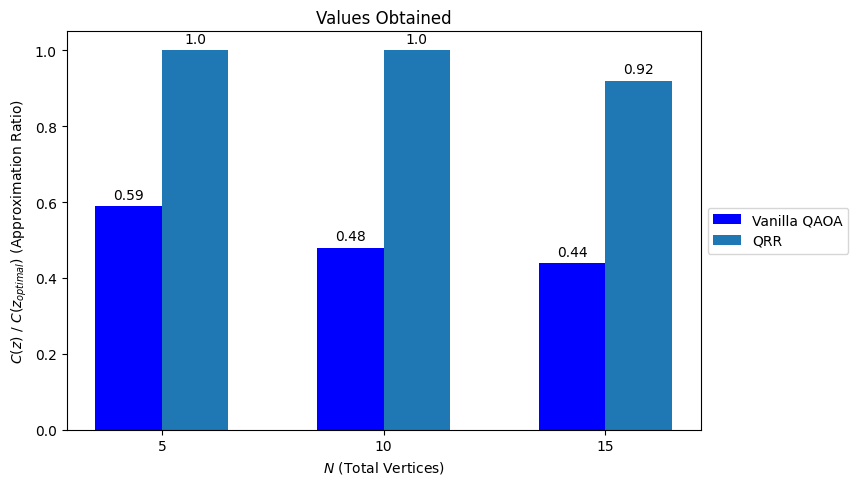

In [ ]:
labels = ['5', '10', '15']

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.around(vanilla_qaoa_average, 2), width, label='Vanilla QAOA', color='blue')
rects2 = ax.bar(x + width/2, np.around(qrr_average, 2), width, label='QRR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$C(z)\ /\ C(z_{optimal})$ (Approximation Ratio)')
ax.set_xlabel('$N$ (Total Vertices)')
ax.set_title('Values Obtained')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

fig.set_size_inches(10, 5, forward=True)

plt.show()

## 3). Problem 2: Knapsack

As mentioned in the presentation, we are interested in studying the QRR algorithm on different type of optimization problems. MaxCut, the problem that is heavily discussed in the original paper, is an optimization problem that doesn't have constraints (all solutions are feasible solutions). While Knapsack is an optimization problem that do have 1 constraint, the maximum weight constraint.

### 3.1). Prepare the Problem Instances

We will test the QRR on 5 different Knapsack problem scenarios.

In [ ]:
def problem_scenarios(num_scenario):

    if num_scenario == 1:
        weight_list = [2, 2, 2, 3]
        value_list = [4, 4, 1, 2]
        max_weight = 3
        opt_val = 4
        qubits = 4+3

    if num_scenario == 2:
            weight_list = [2, 6, 5, 5, 4]
            value_list = [15, 15, 16, 17, 17]
            max_weight = 8
            opt_val = 32
            qubits = 5+4

    if num_scenario == 3:
            weight_list = [2, 4, 5, 2, 3]
            value_list = [18, 17, 19, 18, 19]
            max_weight = 8
            opt_val = 55
            qubits = 5+4

    if num_scenario == 4:
            weight_list = [5, 4, 1, 5, 4, 1, 2, 3]
            value_list = [17, 16, 17, 15, 18, 17, 16, 18]
            max_weight = 8
            opt_val = 68
            qubits = 8+4

    if num_scenario == 5:
            weight_list = [3, 2, 5, 1, 4, 4, 1, 4]
            value_list = [16, 17, 17, 19, 18, 16, 17, 19]
            max_weight = 9
            opt_val = 72
            qubits = 8+4

    return weight_list, value_list, max_weight, opt_val, qubits

And below is the function to check whether a bitstring is a feasible solution for a particular Knapsack problem or not.

In [ ]:
def check_solution(bitstring, weights_list, values_list, max_weight):

    solution_weight = np.sum(bitstring*weights_list)

    if solution_weight <= max_weight:
        solution_value = np.sum(bitstring*values_list)

        return True, solution_weight, solution_value

    else:

        return False, 0, 0

### 3.2). QAOA and QRR Implementation of Knapsack

The QAOA implementation is adapted from [3].

For this Knapsack problems, we want to try increasing the number of QAOA layers to 200 layers. But this will take quite a lot of time to train. Inspired from [3], to save some runtime in this demo, we will mimic the annealing process of adiabatic quantum computation with QAOA. The way to do this is to slowly lower the value of $\beta$ angles (the Mixer Hamiltonian parameters) and slowly increase the value of $\gamma$ angles (the Cost Hamiltonian parameters) as we progress through the QAOA layers.

Every circuit measurement (sampling) is done with 10000 shots.

In [ ]:
def from_Q_to_Ising(Q, offset):
    """Convert the matrix Q to elements of J (two-qubit terms) and h (single-qubit terms)"""
    n_qubits = len(Q)  # Get the number of qubits (variables) in the QUBO matrix
    # Create default dictionaries to store h and pairwise interactions J
    h = defaultdict(int)
    J = defaultdict(int)

    # Loop over each qubit (variable) in the QUBO matrix
    for i in range(n_qubits):
        # Update the magnetic field for qubit i based on its diagonal element in Q
        h[(i,)] += Q[i, i] / 2
        # Update the offset based on the diagonal element in Q
        offset += Q[i, i] / 2
        # Loop over other qubits (variables) to calculate pairwise interactions
        for j in range(i + 1, n_qubits):
            # Update the pairwise interaction strength (J) between qubits i and j
            J[(i, j)] += Q[i, j] / 4
            # Update the magnetic fields for qubits i and j based on their interactions in Q
            h[(i,)] += Q[i, j] / 4
            h[(j,)] += Q[i, j] / 4
            # Update the offset based on the interaction strength between qubits i and j
            offset += Q[i, j] / 4
    # Return the magnetic fields, pairwise interactions, and the updated offset
    return h, J, offset


In [ ]:
# -----------------------------   QAOA sampler for Knapsack Problem (output = bitstring samples) ------------------------------------
shots = 10000  # Number of samples used
dev = qml.device("default.qubit", shots=shots)

@qml.qnode(dev)
def qaoa_sampler(gammas, betas, h, J, num_qubits):
    wmax = max(
        np.max(np.abs(list(h.values()))), np.max(np.abs(list(h.values())))
    )  # Normalizing the Hamiltonian is a good idea
    p = len(gammas)
    # Apply the initial layer of Hadamard gates to all qubits
    for i in range(num_qubits):
        qml.Hadamard(wires=i)
    # repeat p layers the circuit shown in Fig. 1
    for layer in range(p):
        # ---------- COST HAMILTONIAN ----------
        for ki, v in h.items():  # single-qubit terms
            qml.RZ(2 * gammas[layer] * v / wmax, wires=ki[0])
        for kij, vij in J.items():  # two-qubit terms
            qml.CNOT(wires=[kij[0], kij[1]])
            qml.RZ(2 * gammas[layer] * vij / wmax, wires=kij[1])
            qml.CNOT(wires=[kij[0], kij[1]])
        # ---------- MIXER HAMILTONIAN ----------
        for i in range(num_qubits):
            qml.RX(-2 * betas[layer], wires=i)

    return qml.sample()

In [ ]:
qaoa_val_knapsack = []
qrr_val_knapsack = []
opt_val_knapsack = []

for i in range(5):
    weights_list, values_list, maximum_weight, opt_val, _ = problem_scenarios(i+1)
    print("Scenario", i+1)

    N = len(values_list)
    N_slack_bits = int(np.floor(np.log2(maximum_weight)) + 1) # total number of slack bits required as function of the maximum weight

    Q = -np.diag(values_list) # for now this only contains the value term without the weight term

    # pad the weight_list and Q to accomodate the slack bits
    QT = np.pad(Q, ((0, N_slack_bits), (0, N_slack_bits)))
    weight_list_padded = np.append(weights_list, [2**k for k in range(N_slack_bits)])

    # calculate the constant multiplier for the weight penalty
    penalty_weight = max(values_list)+1

    # add the constant penalty weight on the QUBO matrix QT (top half filled)
    for i in range(N + N_slack_bits):
        QT[i,i] += penalty_weight * weight_list_padded[i] * (weight_list_padded[i] - 2 * maximum_weight)

        for j in range(i + 1, N + N_slack_bits):
            QT[i,j] += 2 * penalty_weight * weight_list_padded[i] * weight_list_padded[j]

    # calculate the constant energy offset
    offset = penalty_weight * maximum_weight**2 # the offset constant term

    opt_val_knapsack += [opt_val]
    print("Optimal Value:", opt_val_knapsack[-1])

    # QAOA
    h, J, zoffset = from_Q_to_Ising(QT, offset) # collecting the h and J terms, and also the constant energy offset

    # Annealing schedule for QAOA
    num_layer = 200
    betas = np.linspace(0, 1, num_layer)[::-1]  # Parameters for the mixer Hamiltonian
    gammas = np.linspace(0, 1, num_layer)  # Parameters for the cost Hamiltonian (Our Knapsack problem)

    # QAOA Bitstrings
    qaoa_solutions = qaoa_sampler(gammas, betas, h, J, num_qubits=len(QT))

    # Filtering the bitstrings to only feasible bitstrings (for QAOA performance calculation)
    feasible_count = 0
    opt_count = 0
    average_value = 0
    for bitstring in qaoa_solutions:
        constraint_fulfill, weight, value = check_solution(bitstring[:N], weights_list, values_list, maximum_weight)
        if constraint_fulfill:
            feasible_count += 1
            average_value += value

            if value == opt_val:
                opt_count += 1
    if feasible_count == 0:
        average_value = 0
    else:
        average_value = average_value/feasible_count

    qaoa_val_knapsack += [average_value]
    print("vanilla QAOA, % Optimal (P Opt) | % Feasible | Average Value:", opt_count/shots, feasible_count/shots, qaoa_val_knapsack[-1])

    # QRR on all the bitstrings sampled from the QAOA
    Z_mat = Z_matrix_from_bitstrings(qaoa_solutions)
    args = {"weights_list": weights_list, "values_list": values_list, "max_weight": maximum_weight, "N": N}
    qrr_solution, qrr_value = relax_and_round(Z_mat, knapsack_cost, args)
    qrr_val_knapsack += [-1*qrr_value]
    print("QRR:", qrr_val_knapsack[-1])

    print("\n")

Scenario 1
Optimal Value: 4
vanilla QAOA, % Optimal (P Opt) | % Feasible | Average Value: 0.0025 0.0486 0.21193415637860083
QRR: 4.0


Scenario 2
Optimal Value: 32
vanilla QAOA, % Optimal (P Opt) | % Feasible | Average Value: 0.001 0.0027 21.037037037037038
QRR: 32.0


Scenario 3
Optimal Value: 55
vanilla QAOA, % Optimal (P Opt) | % Feasible | Average Value: 0.0119 0.204 39.91029411764706
QRR: 53.0


Scenario 4
Optimal Value: 68
vanilla QAOA, % Optimal (P Opt) | % Feasible | Average Value: 0.0 0.0002 49.5
QRR: 68.0


Scenario 5
Optimal Value: 72
vanilla QAOA, % Optimal (P Opt) | % Feasible | Average Value: 0.0 0.0013 56.15384615384615
QRR: 68.0




In [ ]:
print("Optimal Value:", opt_val_knapsack)
print("QAOA:", qaoa_val_knapsack)
print("QRR:", list(np.array(qrr_val_knapsack)))

Optimal Value: [4, 32, 55, 68, 72]
QAOA: [0.21193415637860083, 21.037037037037038, 39.91029411764706, 49.5, 56.15384615384615]
QRR: [4.0, 32.0, 53.0, 68.0, 68.0]


In [ ]:
opt_val_knapsack = [4, 32, 55, 68, 72]
qaoa_val_knapsack = [0.21193415637860083, 21.037037037037038, 39.91029411764706, 49.5, 56.15384615384615]
qrr_val_knapsack = [4.0, 32.0, 53.0, 68.0, 68.0]

### 3.3). The Plot of the Results

As discussed in the presentation, the QRR algorithm also works quite well for a constraint optimization problem like the Knapsack problem. This opens up the possibility of exploration for this algorithm applied to other type of optimization problems.

In [ ]:
opt_list = np.array(opt_val_knapsack)

vanilla_average_value = np.array(qaoa_val_knapsack)/opt_list

qrr = np.array(qrr_val_knapsack)/opt_list

labels = ['1', '2', '3', '4', '5']

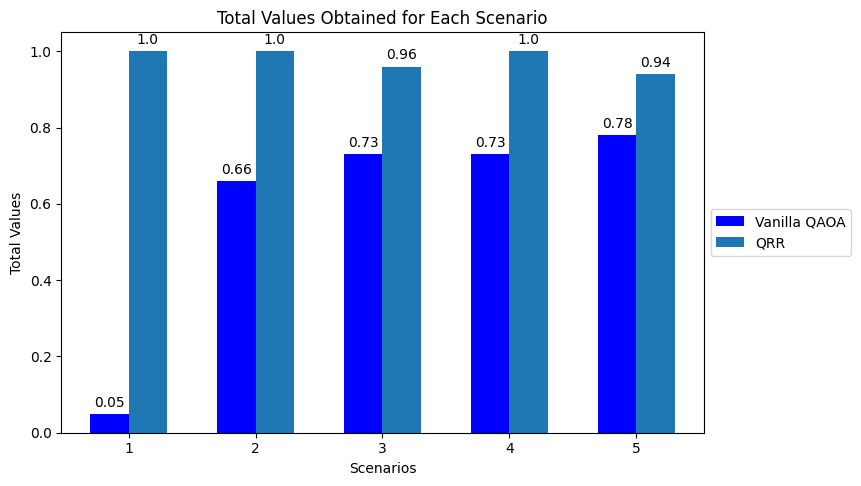

In [ ]:
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.around(vanilla_average_value, 2), width, label='Vanilla QAOA', color='blue')
rects2 = ax.bar(x + width/2, np.around(qrr, 2), width, label='QRR')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total Values')
ax.set_xlabel('Scenarios')
ax.set_title('Total Values Obtained for Each Scenario')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

fig.set_size_inches(10, 5, forward=True)

plt.show()

## 4). References

[1] Dupont, M., & Sundar, B. (2024). Extending relax-and-round combinatorial optimization solvers with quantum correlations. [Phys. Rev. A, 109, 012429](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.109.012429).

[2] Lowe, A. (2024, January 1). QAOA for MaxCut. PennyLane Demos. https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut/

[3] Montanez, A. (2024, February 29). Quadratic Unconstrained Binary Optimization (QUBO). PennyLane Demos. https://pennylane.ai/qml/demos/tutorial_QUBO/